In [ ]:
import merge_rating_impactFactors from movie_data
import get_movie_names_all, get_match_names, search_rating_via_IMDB from Rating
import get_data_labels, get_train_test_data, RunRandomForest,  plotRadias_fimp, RunMLPClassifier, RunLinearSVC from Random_Forest 

## Fetch Rating  Data  from IMDB API

http://www.omdbapi.com/ provides a RESTful web service to obtain movie information, which enable users to easily retrieve useful movie data. By send all data requests to: http://www.omdbapi.com/?apikey=[yourkey]& and append specified request parameters, movies's basic information are send back as dictionary in response. 

Here is an example for retrieveing informations about "Avatar":


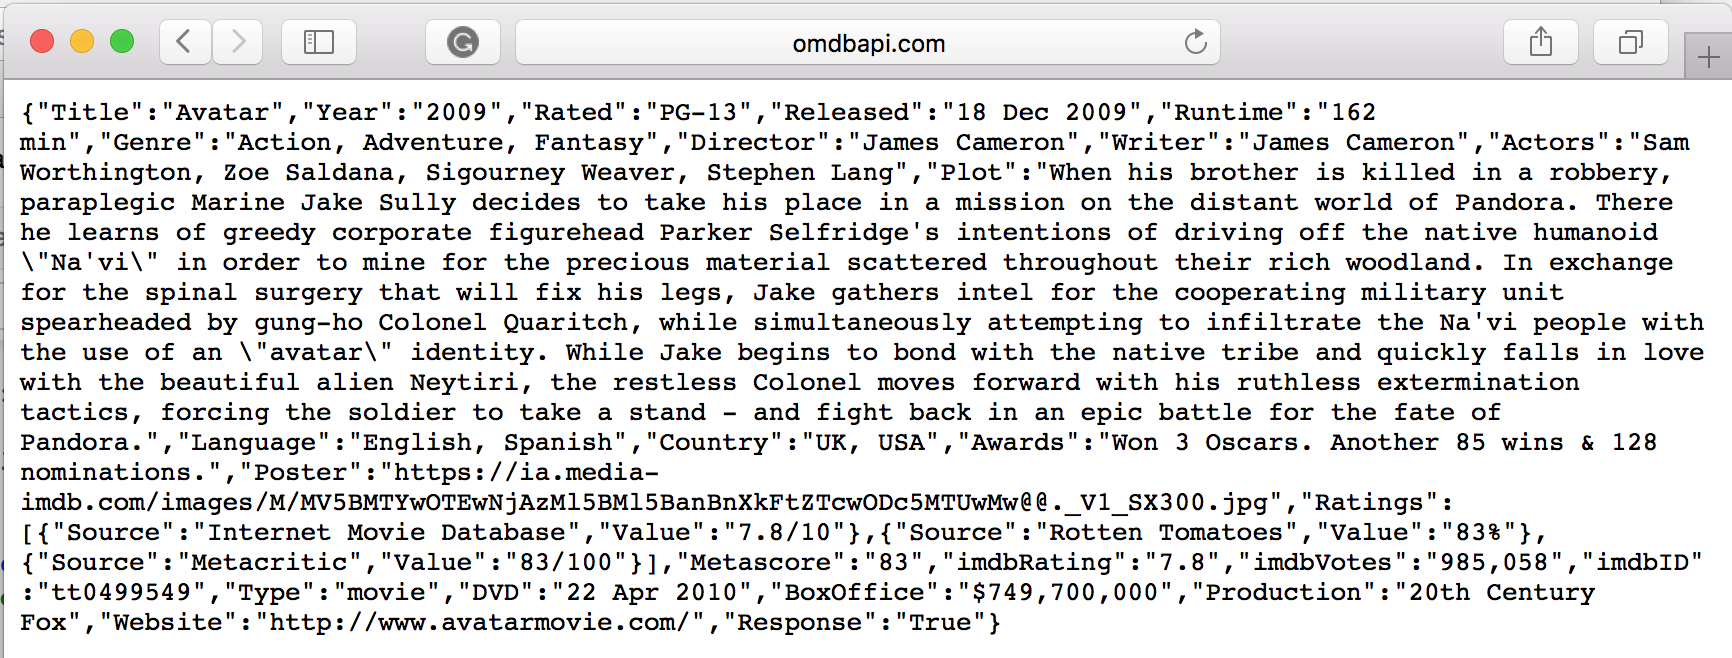

By parsing the url response, we can get data that we expect.  

But a tricky problem we met was that the movie names scrabed from https://www.the-numbers.com/ are not consistent with the movie name displayed on IMDB web pages. Additionally, only exact-matched movie names provided in request url is valid search keywords. Thus, we have to convert the movie names from what we scrabled from the-numbers to what is displayed in IMDB. We wrote codes to automatically transformed some names according to rules:
1. drop "(release year)" at the end of string 
2. replace "’" with "'"
3. replace '—' with ' - '
4. try to replace "and" with "&"
5. try to cut name before "()" or ":"

Some other incosistent names are namnually modified. Rest of incosistent names are directly threw away. 

The codes of this part are much tedious, thus we hidden details and only provided funcions here. 

In [ ]:
movies_names = get_movie_names_all()
new_names = get_match_names()

We now got a list of matched names. In the next step, we set "t=moviename" in reuqest url to retrieves 'imdbRating','Rotten_Tomatoes','Metacritic','imdbVotes','plot' fields in respond content. The retrieved results are stored as a dataframe and savevd in "rating.csv".


In [ ]:
def search_rating_via_IMDB(formal_names, names):
    parameters = {'i':'tt3896198',
                  'apikey':'22f49a17',
                  'plot': 'full'} 
    queryURL = "http://www.omdbapi.com/"
    
    separator = '?'
    
    for i in parameters:
        queryURL = queryURL+separator+i+"="+parameters[i]
        separator = '&'

    movie_rating = pd.DataFrame(columns=['name', 'imdbRating','Rotten_Tomatoes','Metacritic','imdbVotes','plot'])
    
    name = []
    imdbRating = []
    Rotten_Tomatoes = []
    Metacritic = []
    imdbVotes = []
    notfound = []
    plot = []
    
    for i in range(0, len(formal_names)):
        movie = names[i]
        name.append(formal_names[i])
        qword = re.sub(r' ', r'%20', movie).strip()
        query = queryURL + separator + "t=" + qword
        try:
            data = json.load(urllib2.urlopen(query))
            if data['Response'] == 'False':
                query = queryURL + separator + "t=" + qword.replace("and", "&")
                data = json.load(urllib2.urlopen(query))
                if data['Response'] == 'False':
                    idx = qword.find(':')
                    query = queryURL + separator + "t=" + qword[:idx]
                    data = json.load(urllib2.urlopen(query))
                    if data['Response'] == 'False':
                        idx = qword.find('(')
                        query = queryURL + separator + "t=" + qword[:idx]
                        data = json.load(urllib2.urlopen(query))
                        if data['Response'] == 'False':
                            print(str(i) +"  "+ movie)
                            Metacritic.append(None)
                            imdbRating.append(None)
                            Rotten_Tomatoes.append(None)
                            imdbVotes.append(None)
                            plot.append(None)
                            notfound.append(formal_names[i])
                            continue 
            Metacritic.append(getdata(data['Metascore']))
            imdbRating.append(getdata(data['imdbRating']))
            Rotten_Tomatoes.append(getRotTmt(data['Ratings']))
            imdbVotes.append(getdata(data['imdbVotes'].replace(',','')))
            plot.append(data['Plot'])
        except:
            Metacritic.append(None)
            imdbRating.append(None)
            Rotten_Tomatoes.append(None)
            imdbVotes.append(None)
            plot.append(None)
            notfound.append(formal_names[i])
    
    movie_rating.loc[:,'name'] = name
    movie_rating.loc[:,'imdbRating'] = imdbRating
    movie_rating.loc[:,'Rotten_Tomatoes'] = Rotten_Tomatoes
    movie_rating.loc[:,'Metacritic'] = Metacritic
    movie_rating.loc[:,'imdbVotes'] = imdbVotes
    movie_rating.loc[:,'plot'] = plot
    
    movie_rating.set_index('name', inplace=True)
    
    movie_rating.to_csv('ratings.csv')

    return movie_rating, notfound
    

movie_rating,notfound = search_rating_via_IMDB(movies_names, new_names)

## Merge all data and Save in File

In [ ]:
merge_rating_impactFactors()  # save all feature data to movie_data.csv

movie_data = pd.read_csv('movie_data.csv')

## Rating Data Visualization 
Now, we have got four kinds of rating data from imdb, rottentomato and metacritic and box-office of corresping movies. We could do some pre-pocessing and exploaratory analysis at this stage. 

Seaborn visulization comes wirth several nicely libraray that allows us to generate a nice scater matrix of our rating data.  PairGrid showa the interactions between variables. For our rating data set, we know that each type of ratings are probably going to be related; all these variable values and relationships  might vary by levels of box-office. Let's visualize results shown below:

In [ ]:
def rating_visl(movie_data):
    pyplot.figure(figsize=(25, 25)) # width and height in inches
    rois_pairplot = sns.PairGrid(movie_data, vars=["imdbRating", "Rotten_Tomatoes","Metacritic","imdbVotes"], hue='rois')
    rois_pairplot = rois_pairplot.map_diag(plt.hist, linewidth=0, edgecolor="w")
    rois_pairplot = rois_pairplot.map_offdiag(plt.scatter,  linewidth=0.1, edgecolor="w", s=10)
    rois_pairplot = rois_pairplot.add_legend()
    rois_pairplot.savefig("rois_pairplot.jpg")

    gross_pairplot = sns.pairplot(movie_data, vars=["imdbRating", "Rotten_Tomatoes","Metacritic","imdbVotes"], hue='gross')
    gross_pairplot = gross_pairplot.map_diag(plt.hist, linewidth=0, edgecolor="w")
    gross_pairplot = gross_pairplot.map_offdiag(plt.scatter,  linewidth=0.1, edgecolor="w", s=10)
    gross_pairplot = gross_pairplot.add_legend()
    gross_pairplot.savefig('gross_pairplot.jpg')
    
rating_visl(movie_data) # rating visualization 

From the pair-plot shown above, we can see the relationship between different rating values and final box-office. Movies that gained higher rating are more likely to gain higher gross. However, movies that has low bow-office received much dispersed reviews from audience. That means, some good movies are only favored by a small amount of people. Notice that the office-box is easily identifiable by imdbVotes, while others are much difficult to distinguish. This observation agrees with our final results drew from random forests.

##  Movie Box-office Prediction 
……


In [ ]:
def get_data_labels(movie_data):
    features = movie_data.drop(['rois', 'gross', 'name'], axis=1)
    rois = list(movie_data['rois'])
    gross = list(movie_data['gross'])
    features_tag = features.columns
    features = StandardScaler().fit_transform(features)
    return features, features_tag, rois, gross

def get_train_test_data(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, stratify=labels, random_state=1234)
    return X_train, X_test, y_train, y_test


movie_data = pd.read_csv('movie_data.csv')
print("the length of data :" + str(len(movie_data)))
features, rois, gross = get_data_labels(movie_data)
X_train, X_test, y_train, y_test = get_train_test_data(features, gross)

## Random Forest 
Here, we tried several models to clssify our data, among which Random Forest performed best. It reaches accuracy at 64.2%.

Thus, we firstly look at what Random Forests are. They an ensemble learning method for classification, operated by constructing a multitude of decision trees at training time.
It firstly measures the variable importance in a data set to fit a random forest to the data. During the fitting process the out-of-bag error for each data point is recorded and averaged over the forest. The score for the j-th feature is computed and normalized by averaging the difference in out-of-bag error before and after the permutation over all trees. 

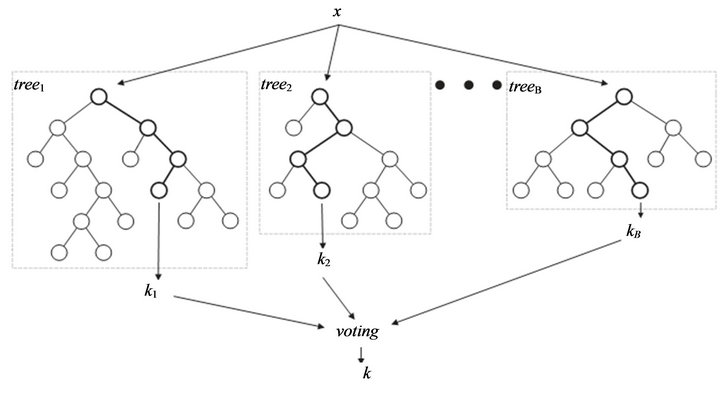

Before using Random Forests to solve the classfication problem, we firstly scaled our data, then splited then into trainset and testset. Here, we are using 50/50 split - 2117 train movies and 2116 test movies. "RunRandomForest()" returns the trained model, predict accuracy and the posibility of each movies belong to one box-office range. We can also get the out-of-bag score computed by sklearn. It is an estimate of the classification accuracy we might expect to observe on new data.

In [ ]:
def RunRandomForest( X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=123456)
    rf.fit(X_train, y_train)
    predicted = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    probability = rf.predict_proba(X_test)
    return rf, accuracy, probability

rf, accuracy, probability = RunRandomForest(X_train, X_test, y_train, y_test)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

## Feature Importance Visualization
To better understand how features are attributed to the final decision, we use ".feature_importances_"  to get weight propotions that the model given to each feature. We then used radar plot to visulaized their importance. The plot image is shown below.

In [ ]:
# Libraries
import matplotlib.pyplot as plt
from math import pi
from matplotlib import pyplot
 
def radar_plt_fimp(rf, features):
    # Set data
    featue_importance = list(zip(features, rf.feature_importances_))
    
    categories = []
    imp_val = []
    for imp in featue_importance:
        categories.append(imp[0])
        imp_val.append(imp[1])

    N = len(categories)

    # need to repeat the first value to close the circular graph:
    imp_val += imp_val[:1]

    # divide the plot / number of variable
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    pyplot.figure(figsize=(10, 10))
    ax = plt.subplot(111,polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)

    # Draw ylabels
    ax.set_rlabel_position(5)
    plt.yticks([0.1,0.2,0.3], ["0.1","0.2","0.3"], color="black", size=15)
    plt.ylim(0,0.3)

    # Plot data
    ax.plot(angles, imp_val, linewidth=1, linestyle='solid')
    ax.fill(angles, imp_val, 'b', alpha=0.1)

    
plotRadias_fimp(rf, features_tag)
radar_plt_fimp(featue_importance)

From the plot above we can see that cast, production companies, imdbvotes are the most import features that dominate the movie's box office. imdbVotes's importance is far more than other ratings such as metacritc, rotten tomatoes and imdbratings. It give us some insights that as for box-office, public attention rate greatly overweights audience reviews. 

## Other Models

We also used multiclassifer and svc to realize classification. Both of them can reach accuracy over 59%. 

### MLPClassifier
A multilayer perceptron (MLP) is a class of feedforward artificial neural network. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function approximator for either classification or regression. Different from other logistic regression, it has one activation layer that can distinguish data that is not linearly separable.

In [ ]:
#****** MLPClassifier  ******#
from sklearn.neural_network import MLPClassifier

def RunMLPClassifier( X_train, X_test, y_train, y_test):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, ), random_state=1)
    clf.fit(X_train, y_train)    
    predicted = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return clf, accuracy
    
clf, MLPCacc = RunMLPClassifier(X_train, X_test, y_train, y_test)
print(MLPCacc)
print(f'Mean accuracy score: {MLPCacc:.3}')

## svc

Here we used Linear Support Vector Classification provided by "sklearn.svm". It implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [ ]:
#****** SVM  ******#
from sklearn.svm import LinearSVC

def RunLinearSVC(X_train, X_test, y_train, y_test):
    svc = LinearSVC(random_state=3)
    svc.fit(X_train, y_train)   
    predicted = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return svc, accuracy
    
svc, SVCacc = RunLinearSVC(X_train, X_test, y_train, y_test)
print(SVCacc)
print(f'Mean accuracy score: {SVCacc:.3}')